# Complexity Correlation

In [8]:
import os
from collections.abc import Callable

import database
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [9]:
db = database.Database("stackoverflow_mysql_queries")

sns.set_context("notebook", font_scale=1.25)

columns = """
QuestionerReputation,
# QuestionerUpvotes,
# QuestionerDownvotes,
# DATEDIFF('{}', QuestionerCreationDate) AS QuestionerCreationDays,
HOUR(TIMEDIFF(QuestionCreationDate, QuestionerCreationDate)) AS QuestionerQuestionHours,
QuestionScore,
QuestionUpvotes,
QuestionDownvotes,
# DATEDIFF('{}', QuestionCreationDate) AS QuestionCreationDays,
QuestionWordCount,
QuestionAnswerCount,
QuestionCommentCount,
# QuestionFavoriteCount,
QuestionViewCount,
QuestionEditCount,
HOUR(TIMEDIFF(AnswerCreationDate, QuestionCreationDate)) AS QuestionAnsweredHours,
# AnswerId,
AnswerIsAccepted,
AnswererReputation,
AnswererUpvotes,
AnswererDownvotes,
HOUR(TIMEDIFF(AnswerCreationDate, AnswererCreationDate)) AS AnswererAnswerHours,
# DATEDIFF('{}', AnswererCreationDate) AS AnswererCreationDays,
AnswerScore,
# AnswerUpvotes,
# AnswerDownvotes,
# DATEDIFF('{}', AnswerCreationDate) AS AnswerCreationDays,
AnswerWordCount,
fs.QuestionSQLComplexity,
#QuestionSQLParseError,
QuestionLanguageComplexity,
fs.AnswerSQLComplexity,
#AnswerSQLParseError,
AnswerLanguageComplexity
"""  # .format(date, date, date, date)

df_features = db.query_df(
    {
        "SELECT": columns,
        "FROM": "features f JOIN features_sql fs ON fs.QuestionId = f.QuestionId",
        "WHERE": "fs.QuestionSQLComplexity IS NOT NULL AND fs.AnswerSQLComplexity IS NOT NULL",
    }
)

In [10]:
def store(function_df, store=None) -> pd.DataFrame:
    """
    Execute and save the function result if the pickle file does not exist.
    If it does exist, the pickle file is loaded.
    :param lambda function_df Function that returns a dataframe.
    :param string store
    """
    if store and os.path.exists(store):
        return pd.read_pickle(store)
    df = function_df()
    if store:
        df.to_pickle(store)
    return df


def plot_heatmap(df, vmin=-1, vmax=1, cmap="RdBu", mask=True, title=None, annot=True, save=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.tight_layout()
    plt.tick_params(labeltop=True, top=True)
    if title:
        plt.title(title)
    sns.heatmap(
        df,
        cmap=cmap,
        square=True,
        ax=ax,
        annot=annot,
        fmt=".2f",
        annot_kws={"fontsize": 7},
        vmin=vmin,
        vmax=vmax,
        mask=mask(df) if callable(mask) else None,
    )
    if save:
        plt.savefig(save, bbox_inches="tight")
    pass
    plt.show()


def calculate_pvalues(df) -> pd.DataFrame:
    return df.corr(method=lambda x, y: stats.spearmanr(x, y, alternative="two-sided")[1]) - np.eye(len(df.columns))

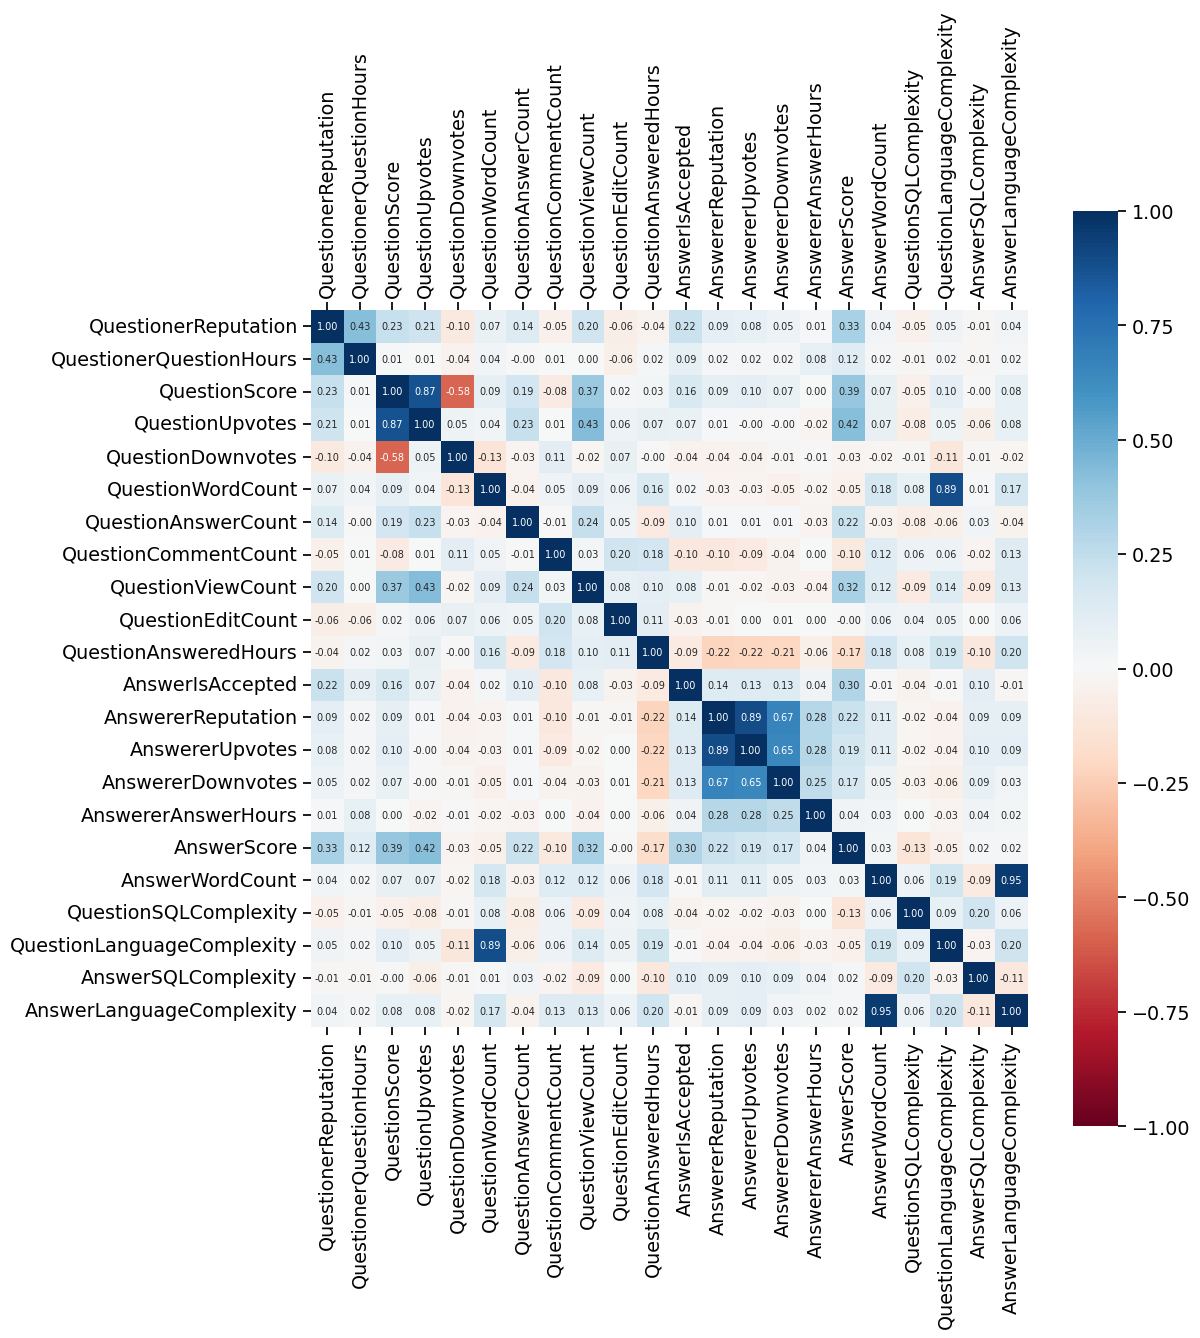

In [11]:
plot_heatmap(
    df_features.corr(method="spearman"),
    mask=None,
    save="./figures/corr-spearman-with-notnull-sql-complexity.svg",
)

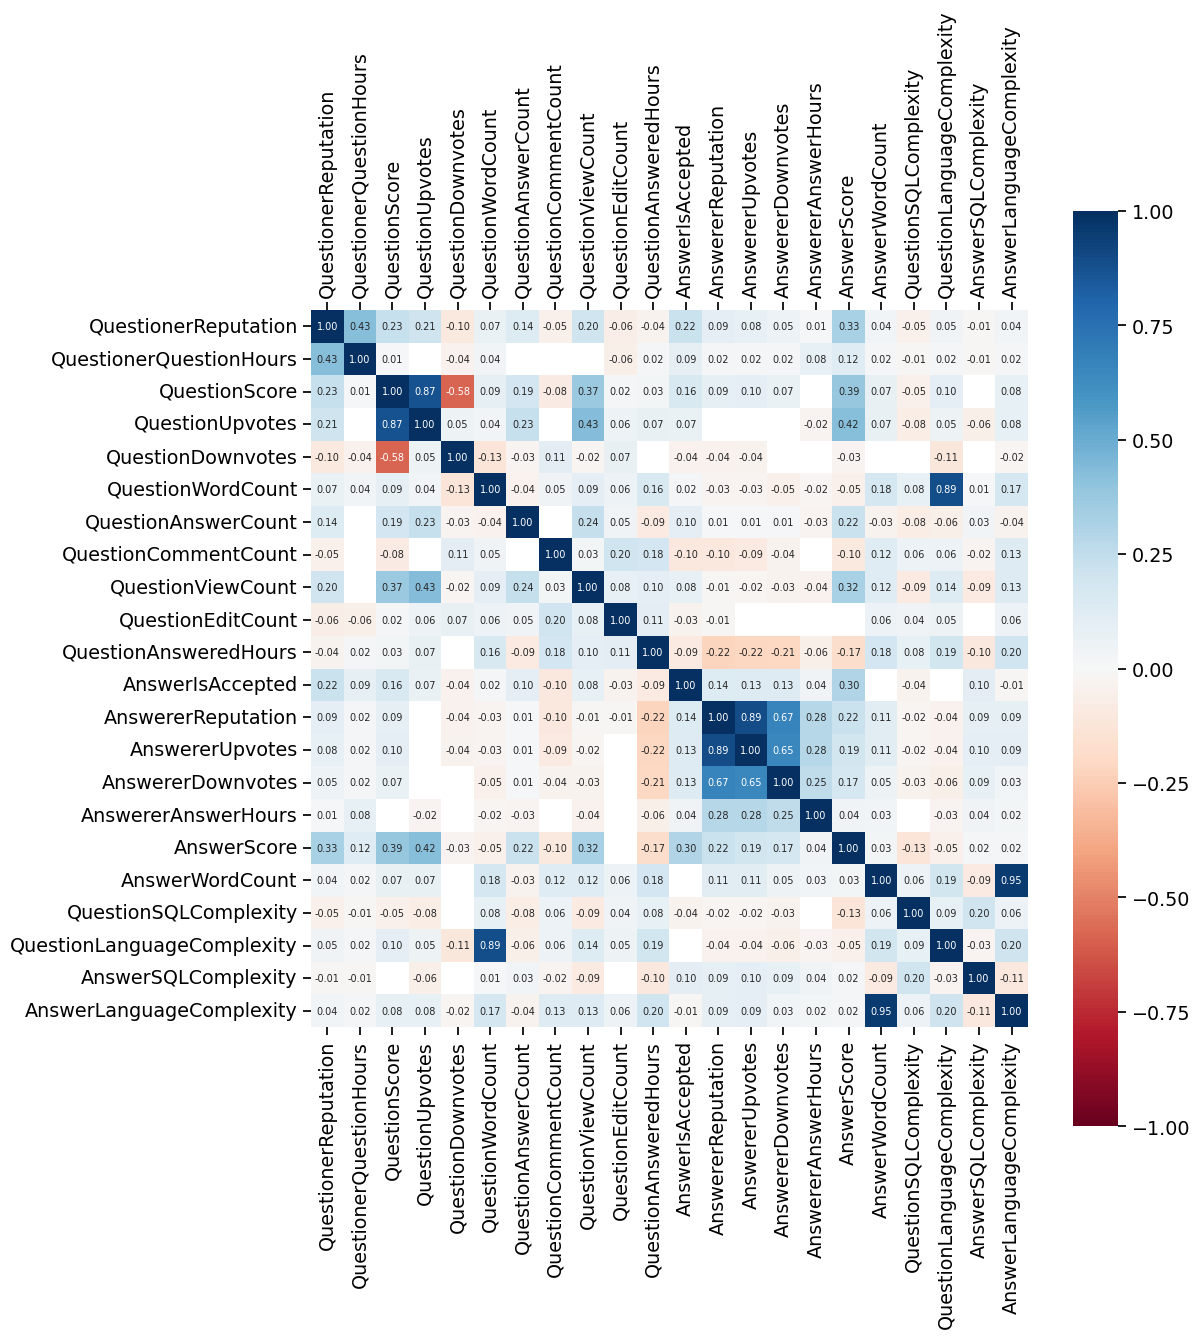

In [12]:
def make_acceptable_pvalue_mask(p_values, threshold=0.05) -> Callable:
    """
    Returns a mask with 0s and 1s that hides data with p_values above a certain value.
    :param float threshold: Threshold for the p-value. Values lower are not masked (shown), values higher are masked (hidden)
    """

    def inner(df):
        """
        :param pandas.DataFrame df: DF being plotted (unused).
        """
        p_values_mask = p_values.copy()
        # Convert everything to 0s and 1s:
        # 0 = acceptable p-value (shown)
        # 1 = unacceptable p-value (hidden)
        p_values_mask[p_values_mask <= threshold] = 0
        p_values_mask[p_values_mask > threshold] = 1
        p_values_mask = p_values_mask.fillna(1).astype("int", errors="ignore")
        return p_values_mask

    return inner


# Show p-values.
# plot_heatmap(calculate_pvalues(df_features), vmin=0, vmax=1, cmap=sns.color_palette("rocket_r", as_cmap=True))

# Hide cells with a high p-value.
plot_heatmap(
    df_features.corr(method="spearman"),
    mask=make_acceptable_pvalue_mask(calculate_pvalues(df_features), 0.05),
    save="./figures/corr-spearman-with-notnull-sql-complexity-with-pvalue-mask.svg",
)

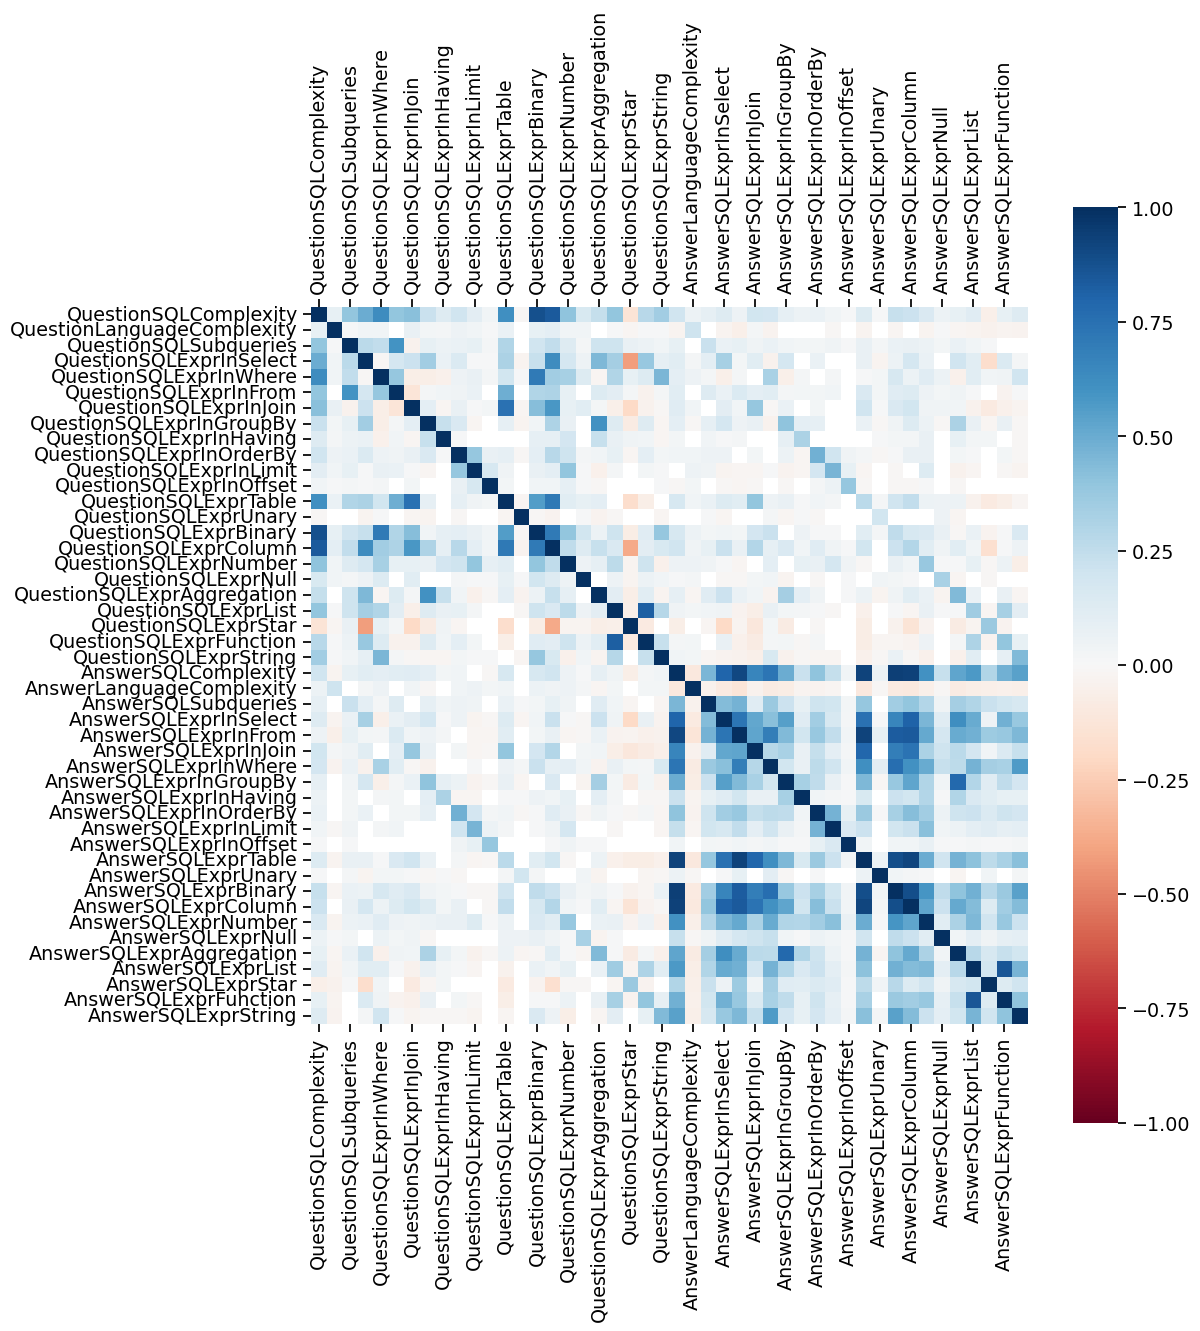

In [13]:
columns = """
fs.QuestionSQLComplexity,
QuestionLanguageComplexity,
# QuestionSQLParseError,
QuestionSQLSubqueries,

QuestionSQLExprInSelect,
QuestionSQLExprInWhere,
QuestionSQLExprInFrom,
QuestionSQLExprInJoin,
QuestionSQLExprInGroupBy,
QuestionSQLExprInHaving,
QuestionSQLExprInOrderBy,
QuestionSQLExprInLimit,
QuestionSQLExprInOffset,

QuestionSQLExprTable,
QuestionSQLExprUnary,
QuestionSQLExprBinary,
QuestionSQLExprColumn,
QuestionSQLExprNumber,
QuestionSQLExprNull,
QuestionSQLExprAggregation,
QuestionSQLExprList,
QuestionSQLExprStar,
QuestionSQLExprFunction,
QuestionSQLExprString,

fs.AnswerSQLComplexity,
AnswerLanguageComplexity,
# AnswerSQLParseError,
AnswerSQLSubqueries,

AnswerSQLExprInSelect,
AnswerSQLExprInFrom,
AnswerSQLExprInJoin,
AnswerSQLExprInWhere,
AnswerSQLExprInGroupBy,
AnswerSQLExprInHaving,
AnswerSQLExprInOrderBy,
AnswerSQLExprInLimit,
AnswerSQLExprInOffset,

AnswerSQLExprTable,
AnswerSQLExprUnary,
AnswerSQLExprBinary,
AnswerSQLExprColumn,
AnswerSQLExprNumber,
AnswerSQLExprNull,
AnswerSQLExprAggregation,
AnswerSQLExprList,
AnswerSQLExprStar,
AnswerSQLExprFunction,
AnswerSQLExprString
"""  # .format(date, date, date, date)

df_features_sql = db.query_df(
    {
        "SELECT": columns,
        "FROM": "features_sql fs",
        "LEFT JOIN": "features f ON fs.QuestionId = f.QuestionId",
        "WHERE": "fs.QuestionSQLComplexity IS NOT NULL AND fs.AnswerSQLComplexity IS NOT NULL",
    }
)

plot_heatmap(
    df_features_sql.corr(method="spearman"),
    mask=make_acceptable_pvalue_mask(calculate_pvalues(df_features_sql), 0.05),
    annot=False,
    save="./figures/corr-spearman-sql-features.svg",
)

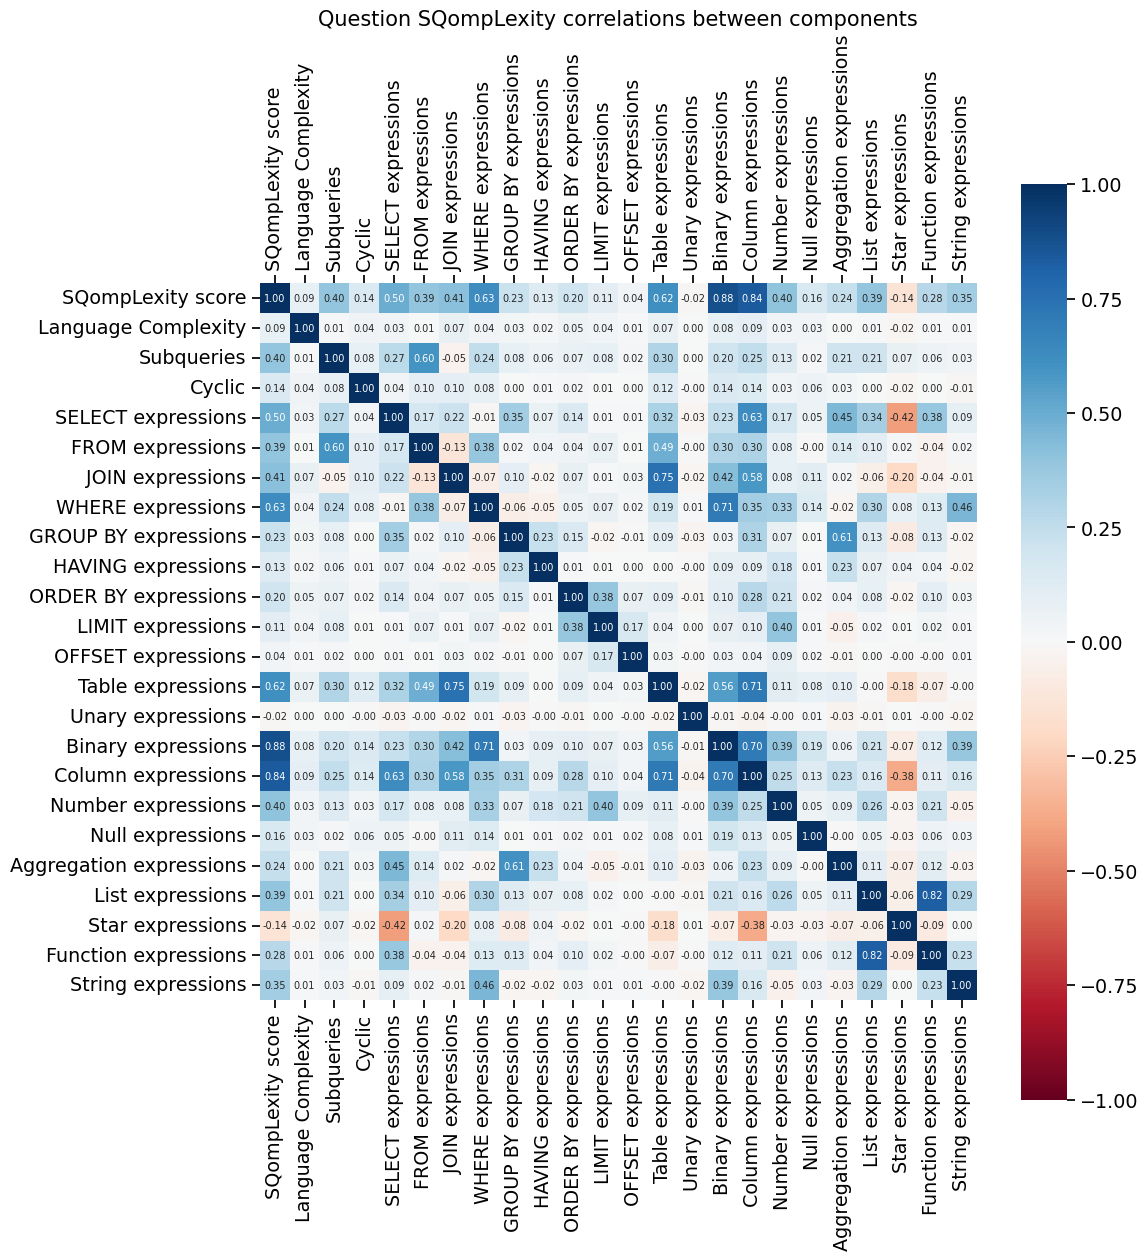

In [18]:
columns = """
fs.QuestionSQLComplexity AS "SQompLexity score",
QuestionLanguageComplexity AS "Language Complexity",
QuestionSQLSubqueries AS "Subqueries",
QuestionSQLIsCyclic AS "Cyclic",

QuestionSQLExprInSelect AS "SELECT expressions",
QuestionSQLExprInFrom AS "FROM expressions",
QuestionSQLExprInJoin AS "JOIN expressions",
QuestionSQLExprInWhere AS "WHERE expressions",
QuestionSQLExprInGroupBy AS "GROUP BY expressions",
QuestionSQLExprInHaving AS "HAVING expressions",
QuestionSQLExprInOrderBy AS "ORDER BY expressions",
QuestionSQLExprInLimit AS "LIMIT expressions",
QuestionSQLExprInOffset AS "OFFSET expressions",

QuestionSQLExprTable AS "Table expressions",
QuestionSQLExprUnary AS "Unary expressions",
QuestionSQLExprBinary AS "Binary expressions",
QuestionSQLExprColumn AS "Column expressions",
QuestionSQLExprNumber AS "Number expressions",
QuestionSQLExprNull AS "Null expressions",
QuestionSQLExprAggregation AS "Aggregation expressions",
QuestionSQLExprList AS "List expressions",
QuestionSQLExprStar AS "Star expressions",
QuestionSQLExprFunction AS "Function expressions",
QuestionSQLExprString AS "String expressions"
"""

plot_heatmap(
    store(
        lambda: db.query_df(
            {
                "SELECT": columns,
                "FROM": "features_sql fs JOIN features f ON fs.QuestionId = f.QuestionId",
                "WHERE": "fs.QuestionSQLComplexity IS NOT NULL AND fs.AnswerSQLComplexity IS NOT NULL",
            }
        ).corr(method="spearman"),
        store="./pickle/df_features_sql_questions_corr.pickle",
    ),
    title="Question SQompLexity correlations between components",
    mask=None,
    save="./figures/corr-spearman-sql-features-question-expressions.svg",
)

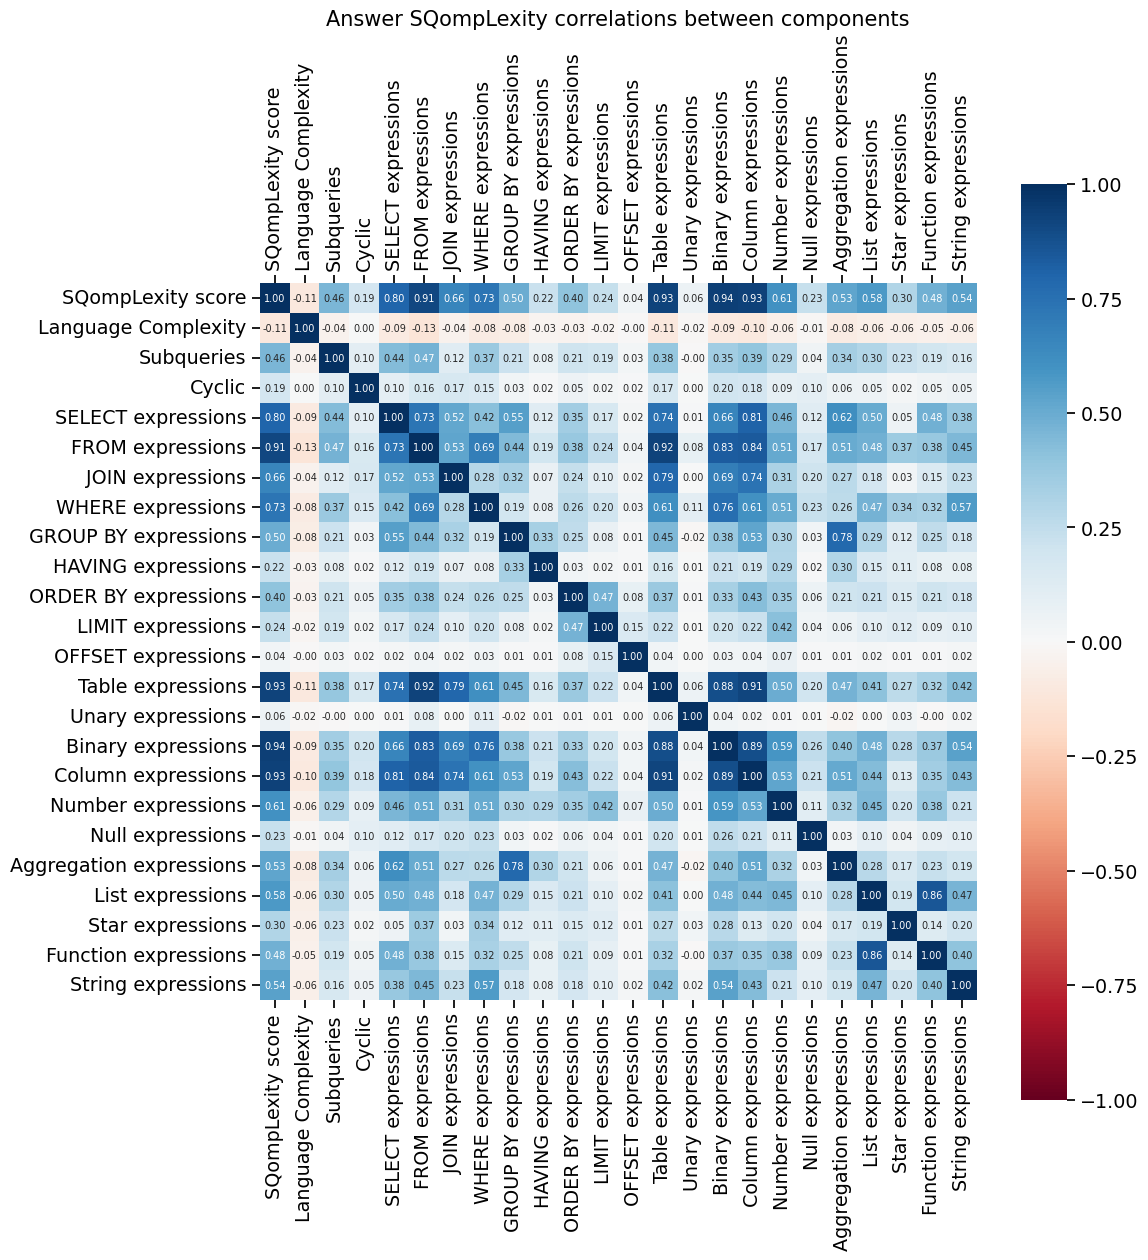

In [19]:
columns = """
fs.AnswerSQLComplexity AS "SQompLexity score",
AnswerLanguageComplexity AS "Language Complexity",
AnswerSQLSubqueries AS "Subqueries",
AnswerSQLIsCyclic AS "Cyclic",

AnswerSQLExprInSelect AS "SELECT expressions",
AnswerSQLExprInFrom AS "FROM expressions",
AnswerSQLExprInJoin AS "JOIN expressions",
AnswerSQLExprInWhere AS "WHERE expressions",
AnswerSQLExprInGroupBy AS "GROUP BY expressions",
AnswerSQLExprInHaving AS "HAVING expressions",
AnswerSQLExprInOrderBy AS "ORDER BY expressions",
AnswerSQLExprInLimit AS "LIMIT expressions",
AnswerSQLExprInOffset AS "OFFSET expressions",

AnswerSQLExprTable AS "Table expressions",
AnswerSQLExprUnary AS "Unary expressions",
AnswerSQLExprBinary AS "Binary expressions",
AnswerSQLExprColumn AS "Column expressions",
AnswerSQLExprNumber AS "Number expressions",
AnswerSQLExprNull AS "Null expressions",
AnswerSQLExprAggregation AS "Aggregation expressions",
AnswerSQLExprList AS "List expressions",
AnswerSQLExprStar AS "Star expressions",
AnswerSQLExprFunction AS "Function expressions",
AnswerSQLExprString AS "String expressions"
"""

plot_heatmap(
    store(
        lambda: db.query_df(
            {
                "SELECT": columns,
                "FROM": "features_sql fs JOIN features f ON fs.QuestionId = f.QuestionId",
                "WHERE": "fs.QuestionSQLComplexity IS NOT NULL AND fs.AnswerSQLComplexity IS NOT NULL",
            }
        ).corr(method="spearman"),
        store="./pickle/df_features_sql_answers_corr.pickle",
    ),
    title="Answer SQompLexity correlations between components",
    mask=None,
    save="./figures/corr-spearman-sql-features-answer-expressions.svg",
)

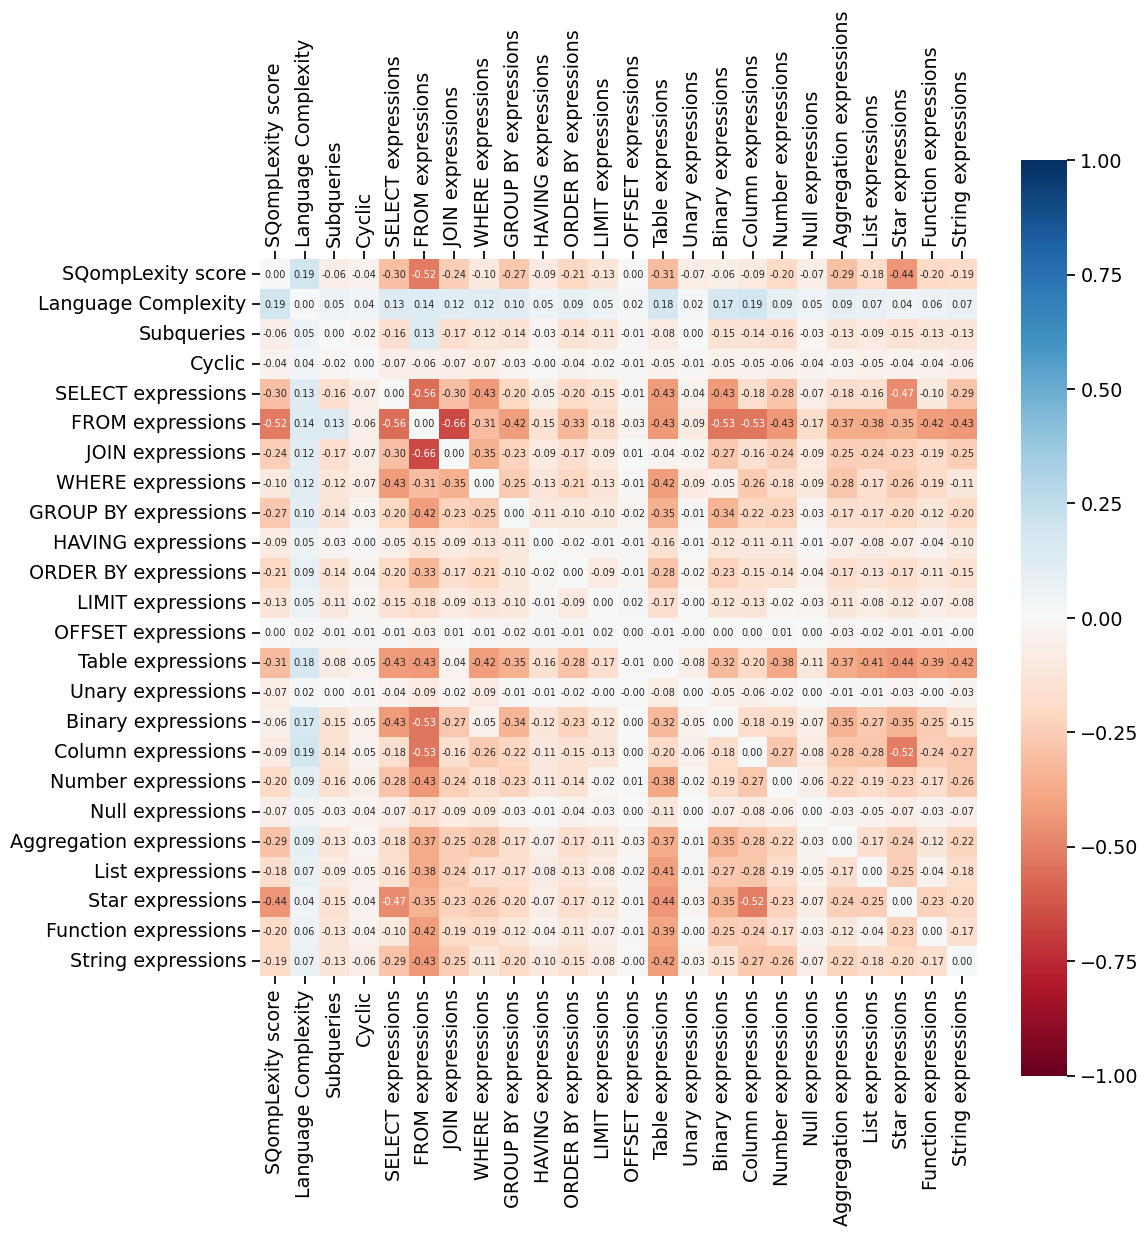

In [20]:
# Calculate the difference between questions and answers:
# - Positive values indicate the cell had a higher value in questions (than answers).
# - Negative values indicate the cell had a lower value in questions (than answers).
plot_heatmap(
    pd.read_pickle("./pickle/df_features_sql_questions_corr.pickle")
    - pd.read_pickle("./pickle/df_features_sql_answers_corr.pickle"),
    save="./figures/corr-spearman-sql-features-question-answer-expressions-difference.svg"
)